Imports and Torch version

In [2]:
# IMPORTS
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as tfs
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import os


print(torch.__version__)

2023-11-15 16:08:16.693115: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-15 16:08:16.939402: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-15 16:08:16.939622: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-15 16:08:16.940965: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-15 16:08:17.067011: I tensorflow/core/platform/cpu_feature_g

2.1.0+cu118


Downloading MNIST Dataset

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_set = MNIST(
    root='./',
    train=True,
    download=True,
    transform = transform
)

test_set = MNIST(
    root='./',
    train=False,
    download=True,
    transform = transform

)

Data Loaders and Training/Validation split

In [4]:
num_workers = 0
batch_size = 128
valid_size = 0.2

num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index , valid_index = indices[split:],indices[:split]

train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         num_workers=num_workers)

Function Gets the number of true positives by comparing the predictions and labels

In [5]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()


Function to delete all files in a directory

In [6]:
def clear_directory(directory_path):
    for filename in os.listdir(directory_path):
        if os.path.isfile(os.path.join(directory_path, filename)):
            os.remove(os.path.join(directory_path, filename))

In [7]:
def check_file_exists(file_path):
    count = 0
    for path in os.listdir(file_path):
        if os.path.isfile(os.path.join(file_path, path)):
            count += 1
    return count

# EXERCISE 1 MLP Model

In [8]:
class MLP(nn.Module):
    # Inilize variables
    def __init__(self):
        super(MLP, self).__init__()
        self.Input = nn.Linear(in_features=784,out_features=512)
        self.Dropout1 = nn.Dropout(0.2)
        self.Hidden = nn.Linear(in_features=512,out_features=512)
        self.Dropout2 = nn.Dropout(0.2)
        self.Predictions = nn.Linear(in_features=512,out_features=10)
    # forward is used to describe the behavior of the model during a feed forward pass
    def forward(self, input_tensor):
        #Flatten the w and h of the image (2D --> 1D)
        x = torch.flatten(input_tensor,start_dim=1)
        x = self.Input(x)
        #Apply non linear activation function relu
        x = F.relu(x)
        x = self.Dropout1(x)
        x = self.Hidden(x)
        x = F.relu(x)
        x = self.Dropout2(x)
        x = self.Predictions(x)
        #Apply Softmax to the output of the model then return the result
        x = F.log_softmax(x, dim=1)
        return x
    # __repr__ returns the models architecture when called
    def __repr__(self):
        return super().__repr__()

Training Model Function

In [9]:
def train_model(model,optimizer,writer,n_epochs=20):
    for epoch in range(n_epochs):
        train_loss = 0
        val_loss = 0
        train_correct = 0
        val_correct = 0
        #Changing model state to train 
        model.train()
        for batch in train_loader: 
            images, labels = batch
            #Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()
            preds = model(images) # Pass or forward batch
            loss = F.cross_entropy(preds, labels) # Calculate loss using cross entropy multiclass
            loss.backward() # Calculate Gradients
            optimizer.step() # Update Weights
            #Add batch loss value to train loss (We want the mean)
            train_loss += loss.item() * images.size(0)
            #Add batch TP (True Positive) value to train correct (We want the mean Accuracy)
            train_correct += get_num_correct(preds, labels) 
        model.eval()
        for batch in valid_loader:
            images, labels = batch
            preds = model(images)
            loss = F.cross_entropy(preds, labels)
            val_loss += loss.item() * images.size(0)
            val_correct += get_num_correct(preds, labels) 
        #Calculating the epochs values for loss acc val_loss and val_accuracy
        train_loss = train_loss / len(train_loader.sampler)
        val_loss = val_loss / len(valid_loader.sampler)
        accuracy = train_correct / len(train_loader.sampler)
        val_accuracy = val_correct / len(valid_loader.sampler)
        #Adding these scalars to tensorboard usinf add_scalar function
        writer.add_scalar('Loss/loss', train_loss, epoch+1)
        writer.add_scalar('Loss/val_loss', val_loss, epoch+1)
        writer.add_scalar('Accuracy/acc', accuracy, epoch+1)
        writer.add_scalar('Accuracy/val_acc', val_accuracy, epoch+1)
        #Shawing the epochs scalar values
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
            epoch+1, 
            train_loss,
            val_loss,
            accuracy,
            val_accuracy
            ))
    writer.close()

Confusion Matrix function

In [10]:
def confusion_matrix_eval(model):
    y_pred = []
    y_tr = []
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    model.eval() # This prepares the model for evaluation
    for batch in test_loader:
        images, labels = batch
        preds = model(images)
        y_pred.extend(np.argmax(preds.detach().numpy(), axis=1))
        y_tr.extend(labels.detach().numpy().tolist())
        loss = F.cross_entropy(preds,labels) # Calculate loss
        test_loss += loss.item() * images.size(0) # update test loss
        _, pred = torch.max(preds, 1) # Convert output probabilities to predicted class
        correct = np.squeeze(pred.eq(labels.data.view_as(pred))) # Compare predictions to true label
        for i in range(len(labels)):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    cm = confusion_matrix(y_true=y_tr, y_pred=y_pred)
    lbls = test_set.classes
    cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lbls)
    fig,ax = plt.subplots(figsize=(30,30))
    cmp.plot(cmap=plt.cm.Blues,ax=ax)
    plt.show()
    test_loss = test_loss/len(test_loader.sampler)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))

Training the MLP model

In [11]:
model = MLP()
path = '/mnt/d/VSCode/TD_Systèmes_Intelligents_Avancés/Results/MLP/'
if(check_file_exists(path)):
    clear_directory(path)
optimizer = optim.RMSprop(model.parameters(),lr=0.01)
writer = SummaryWriter(log_dir=path) #Initializing Tensorboard to store logs in the specified directory
train_model(model,optimizer,writer,20)

Epoch: 1 	Training Loss: 26.071091 	Validation Loss: 1.071685 	Accuracy: 0.494271 	Validation Accuracy: 0.666500
Epoch: 2 	Training Loss: 1.341312 	Validation Loss: 1.079704 	Accuracy: 0.559187 	Validation Accuracy: 0.616750
Epoch: 3 	Training Loss: 1.318814 	Validation Loss: 0.801514 	Accuracy: 0.590250 	Validation Accuracy: 0.750000
Epoch: 4 	Training Loss: 0.961247 	Validation Loss: 0.662515 	Accuracy: 0.689354 	Validation Accuracy: 0.794083
Epoch: 5 	Training Loss: 0.941970 	Validation Loss: 0.515410 	Accuracy: 0.721604 	Validation Accuracy: 0.858833
Epoch: 6 	Training Loss: 0.767752 	Validation Loss: 0.437133 	Accuracy: 0.766396 	Validation Accuracy: 0.877250
Epoch: 7 	Training Loss: 0.721794 	Validation Loss: 0.492807 	Accuracy: 0.784375 	Validation Accuracy: 0.872917
Epoch: 8 	Training Loss: 0.742003 	Validation Loss: 0.435646 	Accuracy: 0.789396 	Validation Accuracy: 0.873167
Epoch: 9 	Training Loss: 0.684584 	Validation Loss: 0.384342 	Accuracy: 0.802396 	Validation Accuracy: 

Matrice de Confusion

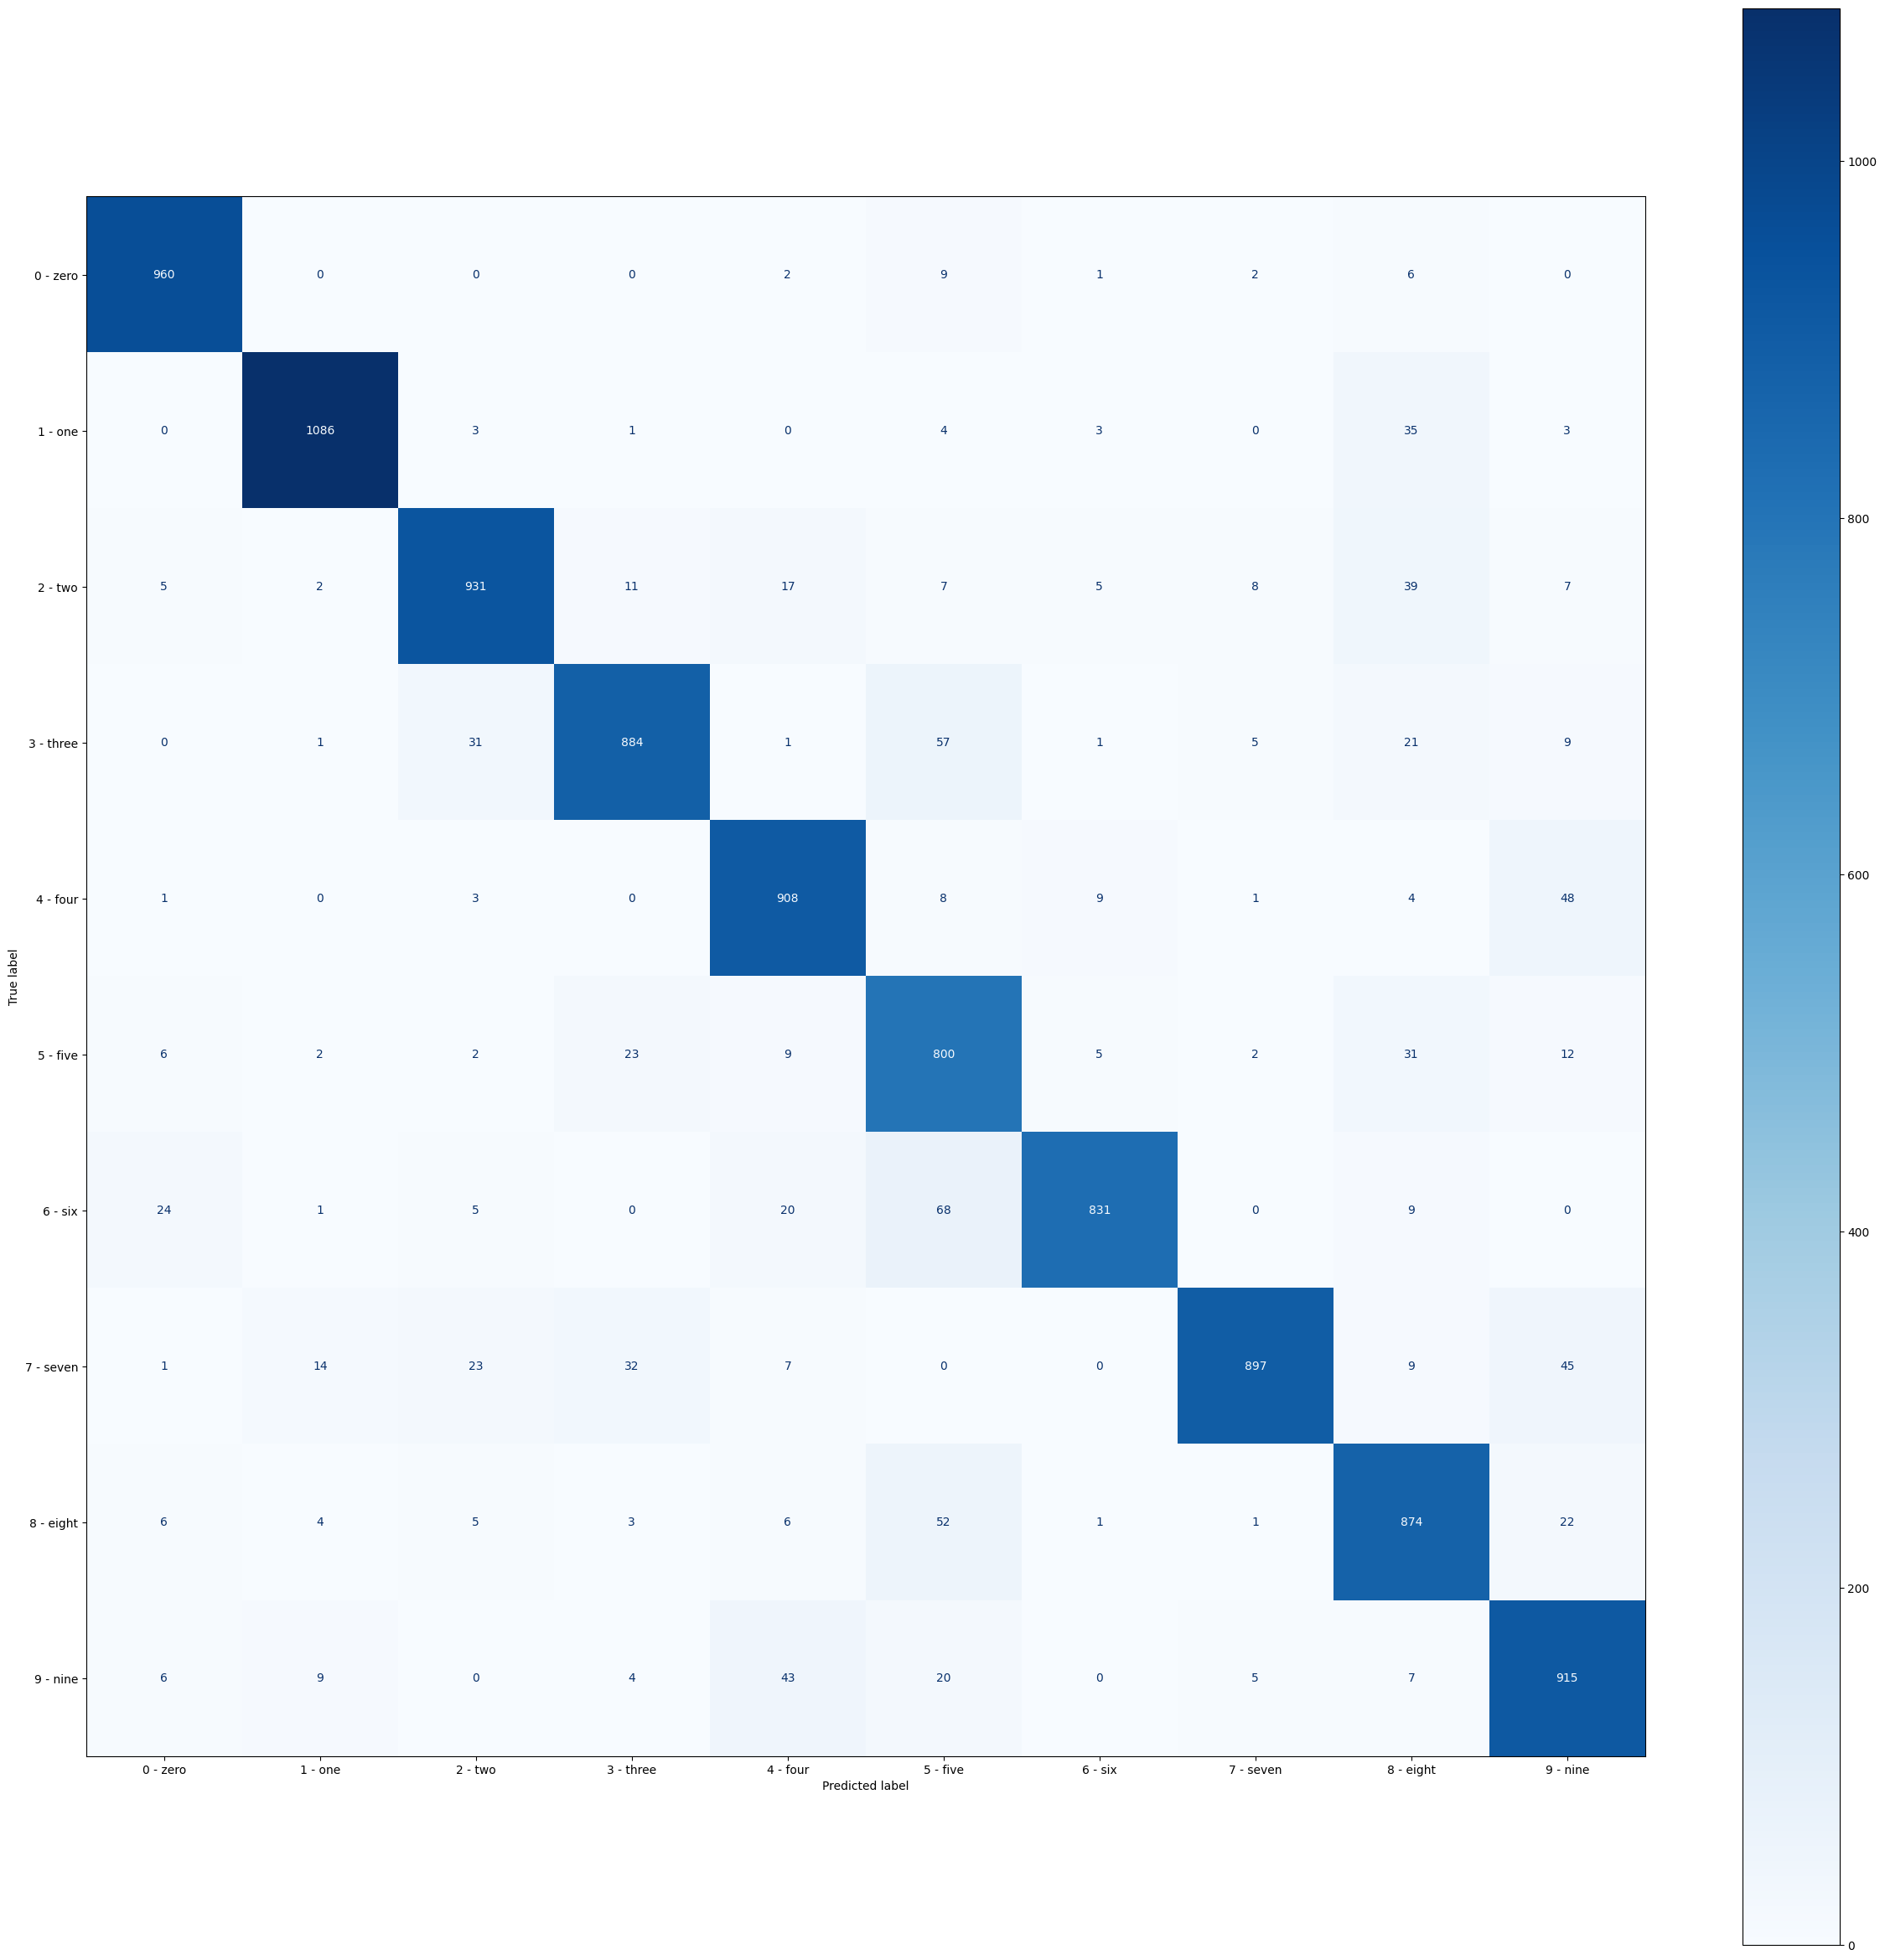

Test Loss: 0.335100

Test Accuracy of     0: 97% (960/980)
Test Accuracy of     1: 95% (1086/1135)
Test Accuracy of     2: 90% (931/1032)
Test Accuracy of     3: 87% (884/1010)
Test Accuracy of     4: 92% (908/982)
Test Accuracy of     5: 89% (800/892)
Test Accuracy of     6: 86% (831/958)
Test Accuracy of     7: 87% (897/1028)
Test Accuracy of     8: 89% (874/974)
Test Accuracy of     9: 90% (915/1009)


In [12]:
confusion_matrix_eval(model)

# EXERCISE 2 CNN

In [13]:
# Define a simple CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc2(x), dim=1)
        return x


In [14]:
model = CNN()
optimizer = optim.SGD(model.parameters(),lr=0.001)
path = '/mnt/d/VSCode/TD_Systèmes_Intelligents_Avancés/Results/CNN/'
if(check_file_exists(path)):
    clear_directory(path)
writer = SummaryWriter(log_dir=path) #Initializing Tensorboard to store logs in the specified directory
train_model(model,optimizer,writer,20)

Epoch: 1 	Training Loss: 2.287160 	Validation Loss: 2.260978 	Accuracy: 0.168771 	Validation Accuracy: 0.330750
Epoch: 2 	Training Loss: 2.235071 	Validation Loss: 2.201496 	Accuracy: 0.325479 	Validation Accuracy: 0.534417
Epoch: 3 	Training Loss: 2.161735 	Validation Loss: 2.105064 	Accuracy: 0.441437 	Validation Accuracy: 0.620083
Epoch: 4 	Training Loss: 2.036218 	Validation Loss: 1.931318 	Accuracy: 0.510667 	Validation Accuracy: 0.655500
Epoch: 5 	Training Loss: 1.827998 	Validation Loss: 1.650093 	Accuracy: 0.557688 	Validation Accuracy: 0.700250
Epoch: 6 	Training Loss: 1.539020 	Validation Loss: 1.306084 	Accuracy: 0.611187 	Validation Accuracy: 0.754083
Epoch: 7 	Training Loss: 1.253781 	Validation Loss: 1.006461 	Accuracy: 0.659854 	Validation Accuracy: 0.807083
Epoch: 8 	Training Loss: 1.029334 	Validation Loss: 0.800020 	Accuracy: 0.712771 	Validation Accuracy: 0.834667
Epoch: 9 	Training Loss: 0.871589 	Validation Loss: 0.664552 	Accuracy: 0.751229 	Validation Accuracy: 0

Confusion Matrix

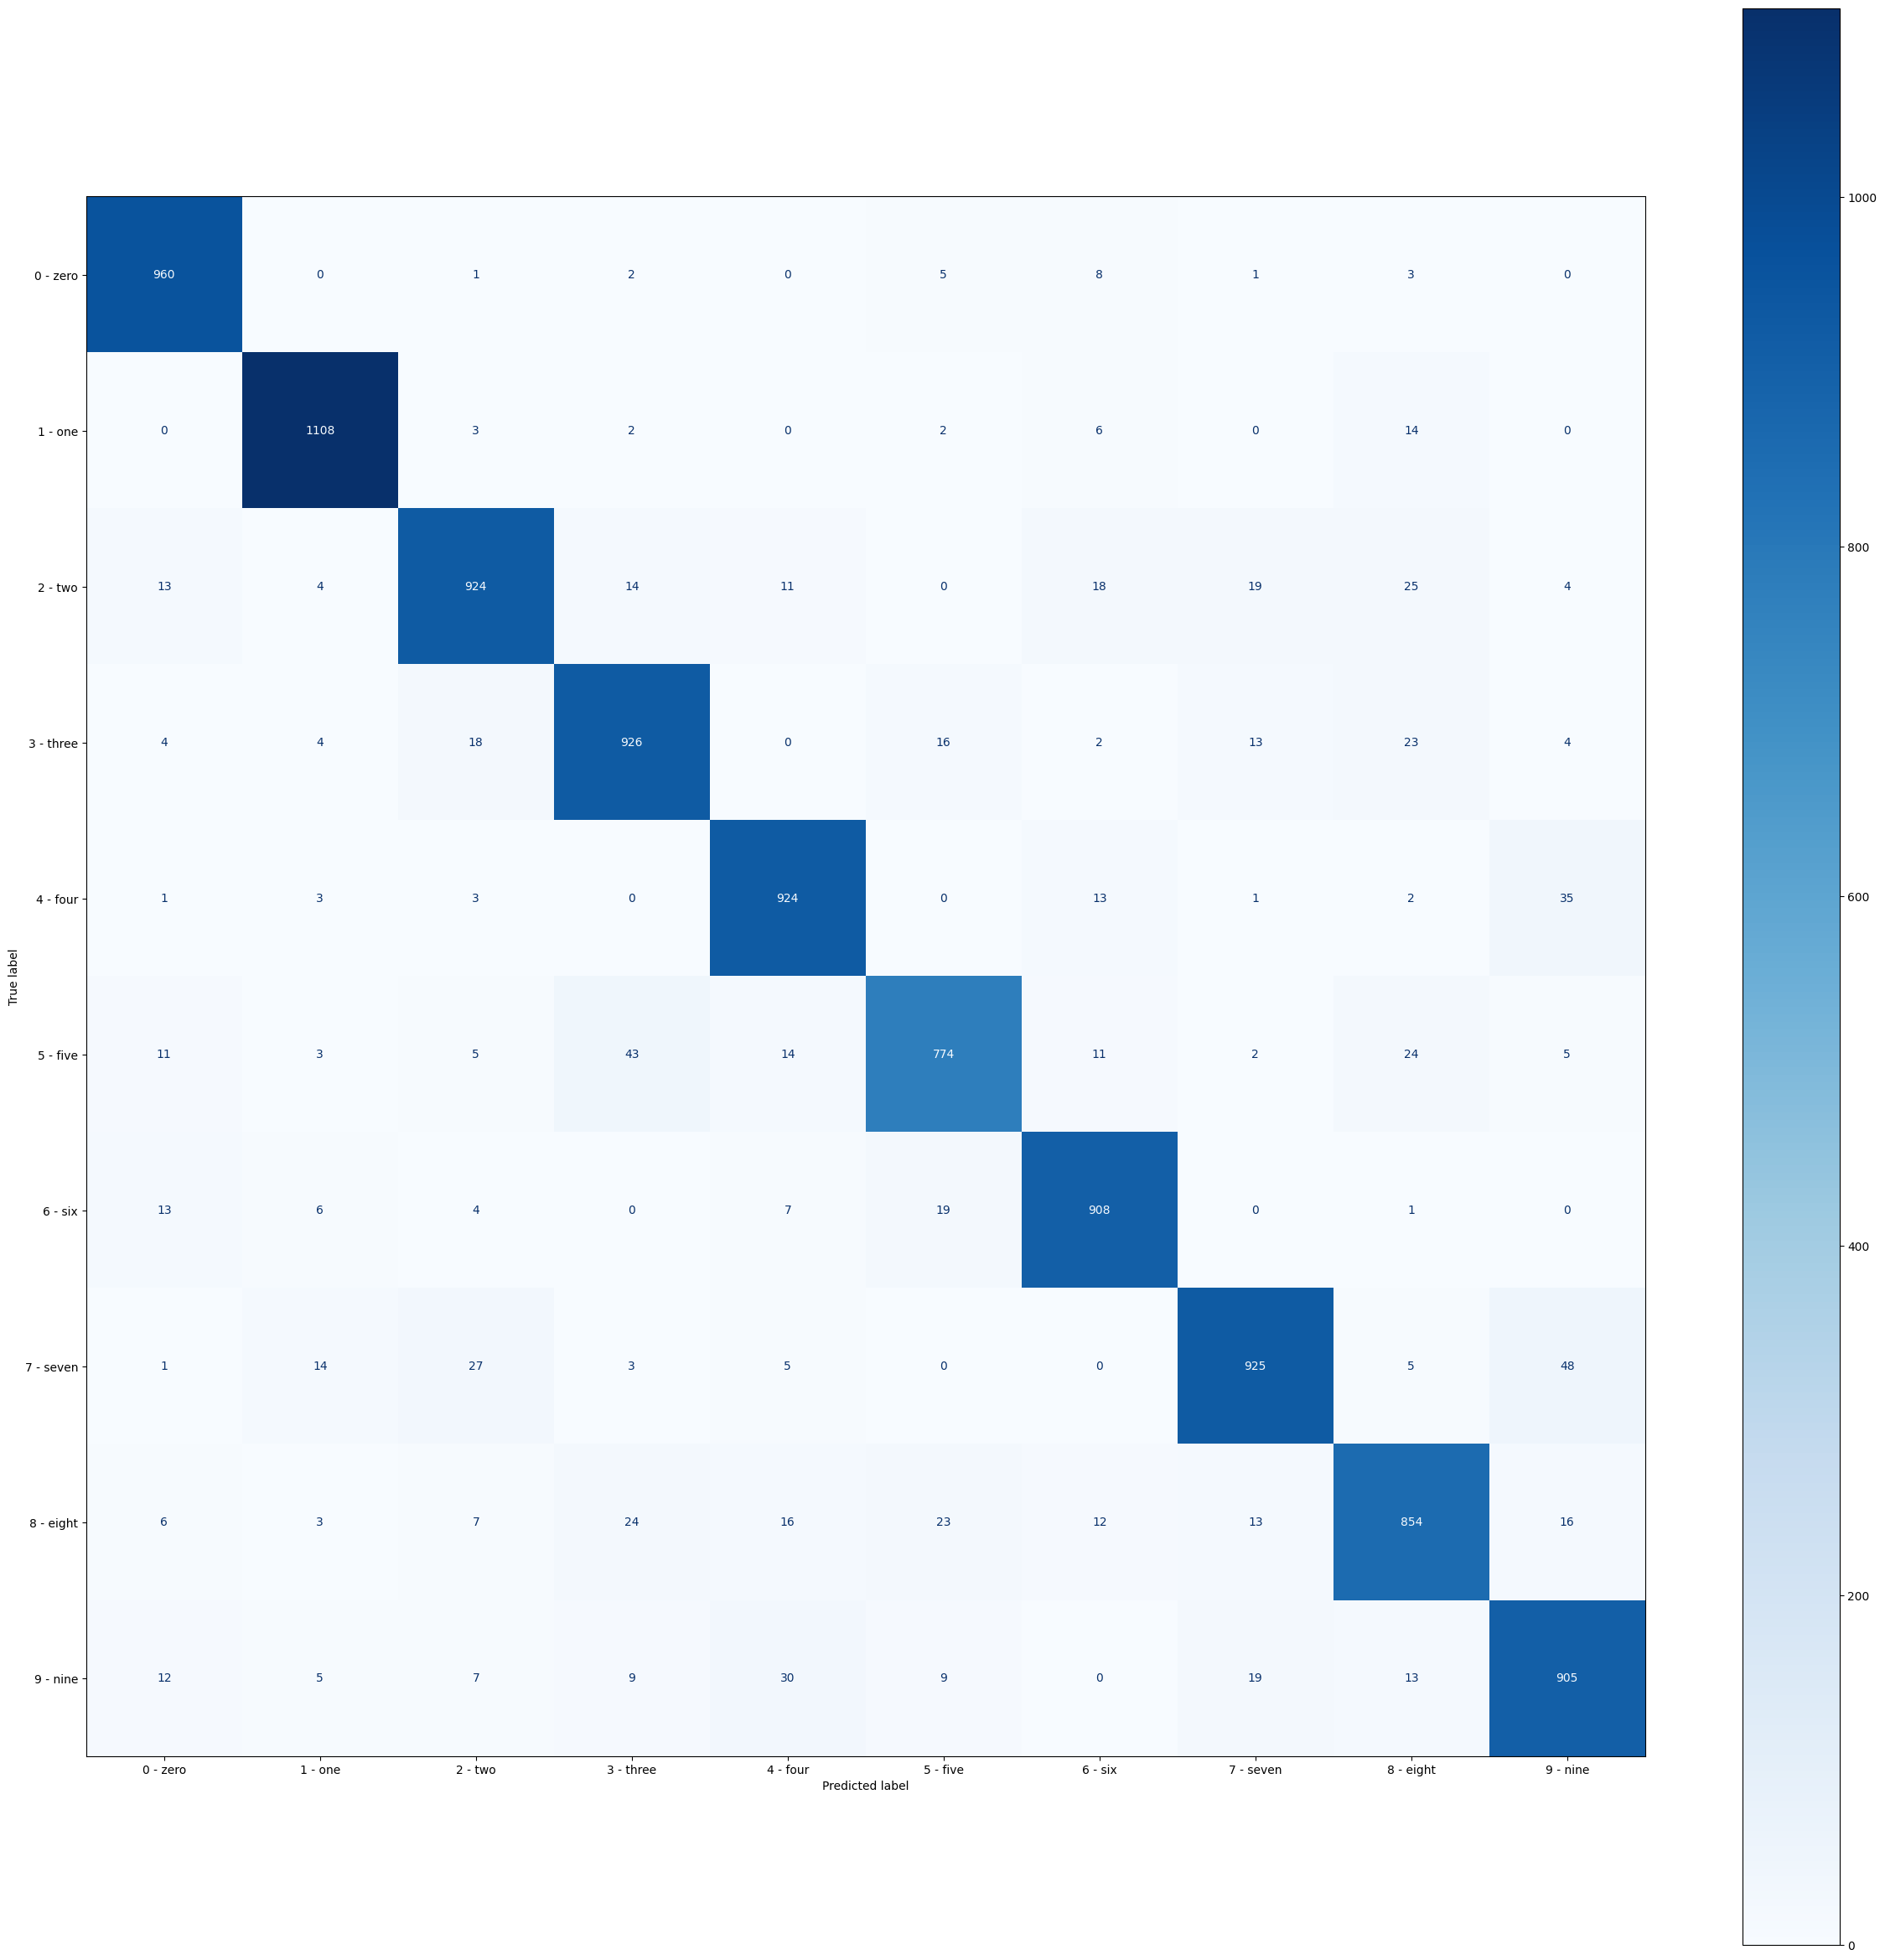

Test Loss: 0.278933

Test Accuracy of     0: 97% (960/980)
Test Accuracy of     1: 97% (1108/1135)
Test Accuracy of     2: 89% (924/1032)
Test Accuracy of     3: 91% (926/1010)
Test Accuracy of     4: 94% (924/982)
Test Accuracy of     5: 86% (774/892)
Test Accuracy of     6: 94% (908/958)
Test Accuracy of     7: 89% (925/1028)
Test Accuracy of     8: 87% (854/974)
Test Accuracy of     9: 89% (905/1009)


In [15]:
confusion_matrix_eval(model)

# EXERCISE 3 Autoencoder

In [16]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Load Data

In [17]:
train_loader = DataLoader(dataset=train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=256, shuffle=False)

Initialize the model, criterion, and optimizer

In [18]:
encoding_dim = 32
autoencoder = Autoencoder(encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

Training the autoencoder

In [21]:
num_epochs = 40
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        optimizer.zero_grad()
        outputs = autoencoder(img)
        loss = criterion(outputs, img)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



Epoch [1/40], Loss: 0.8800
Epoch [2/40], Loss: 0.8785
Epoch [3/40], Loss: 0.8814
Epoch [4/40], Loss: 0.8752
Epoch [5/40], Loss: 0.8797
Epoch [6/40], Loss: 0.8803
Epoch [7/40], Loss: 0.8777
Epoch [8/40], Loss: 0.8758
Epoch [9/40], Loss: 0.8764
Epoch [10/40], Loss: 0.8736
Epoch [11/40], Loss: 0.8743
Epoch [12/40], Loss: 0.8741
Epoch [13/40], Loss: 0.8737
Epoch [14/40], Loss: 0.8737
Epoch [15/40], Loss: 0.8725
Epoch [16/40], Loss: 0.8655
Epoch [17/40], Loss: 0.8693
Epoch [18/40], Loss: 0.8712
Epoch [19/40], Loss: 0.8710
Epoch [20/40], Loss: 0.8673
Epoch [21/40], Loss: 0.8694
Epoch [22/40], Loss: 0.8660
Epoch [23/40], Loss: 0.8686
Epoch [24/40], Loss: 0.8635
Epoch [25/40], Loss: 0.8709
Epoch [26/40], Loss: 0.8644
Epoch [27/40], Loss: 0.8730
Epoch [28/40], Loss: 0.8640
Epoch [29/40], Loss: 0.8709
Epoch [30/40], Loss: 0.8648
Epoch [31/40], Loss: 0.8700
Epoch [32/40], Loss: 0.8663
Epoch [33/40], Loss: 0.8606
Epoch [34/40], Loss: 0.8697
Epoch [35/40], Loss: 0.8644
Epoch [36/40], Loss: 0.8662
E

Testing the autoencoder

In [ ]:
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        encoded_imgs = autoencoder.encoder(img)
        decoded_imgs = autoencoder.decoder(encoded_imgs)

Convert the results to NumPy arrays

In [ ]:
encoded_imgs = encoded_imgs.numpy()
decoded_imgs = decoded_imgs.numpy()

Display Original and Constructed images

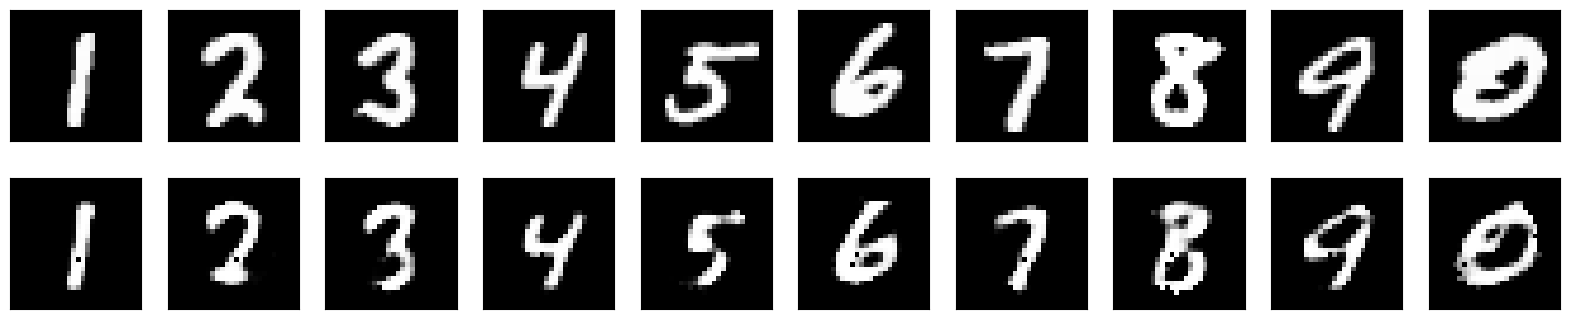

In [ ]:
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original Images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(img[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed Images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# EXERCISE 4 Convolutional Autoencoder

Epoch [1/10], Loss: 0.8284
Epoch [2/10], Loss: 0.8362
Epoch [3/10], Loss: 0.8378
Epoch [4/10], Loss: 0.8575
Epoch [5/10], Loss: 0.8417
Epoch [6/10], Loss: 0.8281
Epoch [7/10], Loss: 0.8330
Epoch [8/10], Loss: 0.8339
Epoch [9/10], Loss: 0.8339
Epoch [10/10], Loss: 0.8256


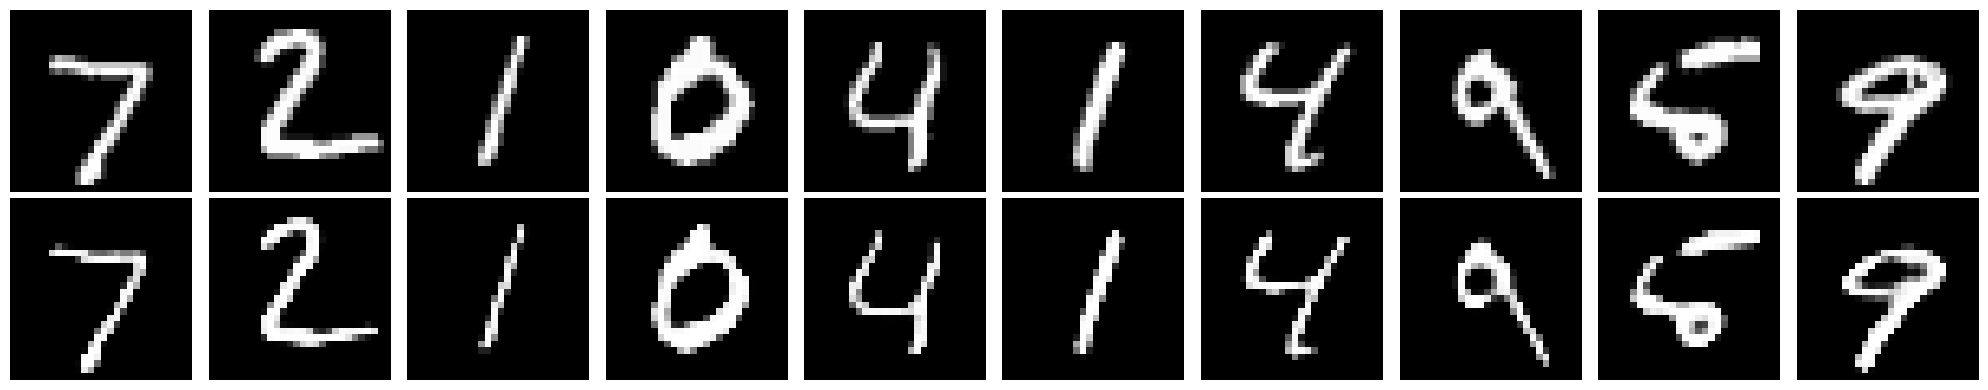

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=1, padding=1),  # output: 16 x 28 x 28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 16 x 14 x 14
            nn.Conv2d(16, 32, 3, stride=1, padding=1),  # output: 32 x 14 x 14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 32 x 7 x 7
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(32, 16, 3, stride=1, padding=1),  # output: 16 x 7 x 7
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),  # output: 16 x 14 x 14
            nn.Conv2d(16, 8, 3, stride=1, padding=1),  # output: 8 x 14 x 14
            nn.ReLU(),
            nn.Upsample(scale_factor=2),  # output: 8 x 28 x 28
            nn.Conv2d(8, 1, 3, stride=1, padding=1),  # output: 1 x 28 x 28
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Data loading and transformation
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, 
                               download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, 
                              download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model, optimizer, and loss function
model = ConvAutoencoder()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Define the number of epochs for training
num_epochs = 10  # Adjust as needed

# Training loop
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        # forward pass
        output = model(img)
        loss = criterion(output, img)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Function to denormalize the image
def denormalize(tensor):
    return tensor * 0.5 + 0.5

# Set the model to evaluation mode
model.eval()

# Get a batch of test images
test_images, _ = next(iter(test_loader))

# Generate reconstructed images
with torch.no_grad():
    reconstructed_images = model(test_images)

# Apply denormalization
test_images = denormalize(test_images)
reconstructed_images = denormalize(reconstructed_images)

# Plot the original and reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))

# Plot original images
for i in range(10):
    axes[0, i].imshow(test_images[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')

# Plot reconstructed images
for i in range(10):
    axes[1, i].imshow(reconstructed_images[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()
